In [ ]:
#Chn2Pyr testing

In [ ]:
!export NEURONHOME=/home/dpd4k4/CA1_model/CA1_model_env/lib64/python3.6/site-packages/neuron/.data/share/nrn

In [2]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
#from scipy.optimize import curve_fit


In [3]:
#do not rerun
h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","nrnmech.dll"))
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
#fileList = ['class_pyramidalcell_original_modified.hoc','class_axoaxoniccell.hoc']
fileList = ['class_pyramidalcell.hoc','class_axoaxoniccell.hoc']
#fileList = ['class_pyramidalcell.hoc']
#for each file, load it into the hoc interpreter so it can be accessed
for item in fileList:
    h.load_file(os.path.join("biophys_components","templates",item))
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()

for i in range(len(callNames)):
    myCell = eval(callNames[i])
#    for sec in h.allsec(myCell):
#        print(sec)

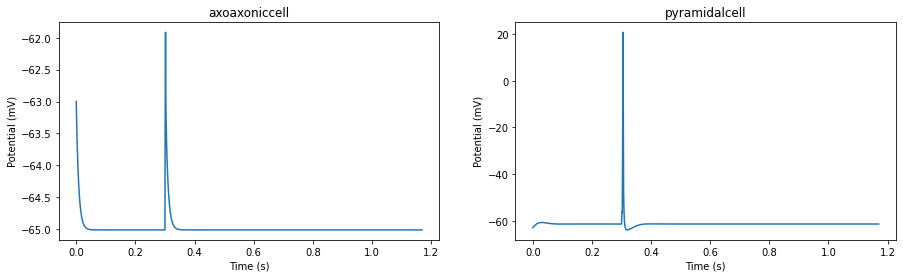

In [4]:

AxonNo = 6
#InjList = [np.arange(400,500,50),#aac
#          np.arange(200,550,50)]#pyr
a = 200
InjList = [np.array([200]),np.array([a])]
allTrials = []
allTrialsVas = []
#allTrialsiNasoma = []
for i in range(len(callNames)):
    myCell = eval(callNames[i])#make the cell
    Ia = InjList[i] /1000# nA ->pA# the current sweep for this particular cell
    allVs = []
    allVas = []
    #alliNasoma = []
    for j in range(len(Ia)):#test it at each current injection and save       
        #iclamp = h.IClamp(myCell.axon[AxonNo](0.5))
        iclamp = h.IClamp(myCell.soma[0](0.5))
        iclamp.delay = 300
        iclamp.dur = 2
        iclamp.amp = Ia[j]
        
        v = h.Vector().record(myCell.soma[0](0.5)._ref_v)
        #va = h.Vector().record(myCell.axon[0](0.5)._ref_v)
        #iNasoma = h.Vector().record(myCell.soma[0](0.5)._ref_ina)
        
        h.dt=0.2
        h.finitialize(-63)
        h.continuerun(1500)
        
        #iNaSoma = np.array(iNasoma)
        V = np.array(v)
        #Va = np.array(va)
        
        
        allVs.append(V)
        #allVas.append(Va)
        #alliNasoma.append(iNasoma)
        
    allTrials.append([allVs])#list of lists; each sublist has the current sweeps for the given cell
    #allTrialsVas.append([allVas])
    #allTrialsiNasoma.append([alliNasoma])
    
res = np.concatenate(allTrials,axis=1)[0].T#how I plotted it the first time.
#resVa = np.concatenate(allTrialsVas,axis=1)[0].T#how I plotted it the first time.
#resIna =  np.concatenate(allTrialsiNasoma,axis=1)[0].T#how I plotted it the first time.

time = np.arange(0,res.shape[0]*h.dt/1000,h.dt/1000)#time in seconds


"""
start = 0
fig,axs = plt.subplots(1,2,figsize=(15,4))
axs[0].plot(time[:5850],res[:5850,start:start+len(InjList[1])])
axs[0].set_title('pyramidal cell Soma')
axs[0].set_xlim([0.25, 0.35])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Potential (mV)')

axs[1].plot(time[:5850],resVa[:5850,start:start+len(InjList[1])])
axs[1].set_xlim([0.25, 0.35])
axs[1].set_title('pyramidal cell axon')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Potential (mV)')


plt.show()


"""
fig,axs = plt.subplots(1,2,figsize=(15,4))
plt.subplots_adjust(hspace=0.5)
start,k = 0,0
for j in range(2):
    axs[j].plot(time[:5850],res[:5850,start:start+len(InjList[k])])
    axs[j].set_title(callNames[k].split('.')[1].split('()')[0])
    axs[j].set_xlabel('Time (s)')
    axs[j].set_ylabel('Potential (mV)')
    start += len(InjList[k])

    k+=1

#plt.savefig('current sweeps.png',dpi=500)

In [3]:
callNames

['h.axoaxoniccell()', 'h.pyramidalcell()']

In [3]:
def getSynName(paramsDict):# so you don't have to track it down in the synapses.py file
    '''
    assumes file w/ synapses is called 'synapses.py' and is the root directory
    assumes paramsDict has filename of the .json
    assumes the synapse is initialized as the variable 'lsyn' for example:
    lsyn = h.pyr2int(blablablah) 
    
    '''
    if type(paramsDict) == dict:
        fileName = paramsDict['filename']
    else:
        fileName = paramsDict
        
    fp = open(os.path.join("biophys_components","synaptic_models",fileName))
    data =json.load(fp)
    
    with open('synapses.py') as f:
        for i,item in enumerate(f):
            if ('add_synapse_model' in item) & (data['level_of_detail'] in item):
                funcName = item.split('add_synapse_model')[1].split('(')[1].split(',')[0]#very specific to how synapses.py is organized. not recommended)

    with open('synapses.py') as f:
        found = 0
        decLine = ''
        for i, item in enumerate(f):
            if 'def '+funcName in item:
                found = 1
                
            if (found == 1) & ('lsyn' in item):
                decLine = item
                found = 0 #only want the one
        synName = decLine.split('h.')[1].split('(')[0]
    return synName

In [5]:
#now get the synapse currents available

In [4]:
def getSyn_vars(fileName,sectionName,key_str):
    '''
    takes json name, the mod file section heading name, and the string you want to search in it.
    i.e., to get all the synaptic conductances' variable names:
    getSyn_vars('PN2CHN.json','RANGE','gbar')
    returns
    ['gbar_nmda', 'gbar_ampa']
    for a mod file with nmda and ampa, for example an E->I synapse
    
    or to get all the synaptic current variable names:
    getSyn_vars('PN2CHN.json','NONSPECIFIC_CURRENT','i')
    
    '''
    
    modFile = getSynName(fileName)+'.mod'
    with open(os.path.join('biophys_components','mechanisms','modfiles',modFile)) as f:
        modDat = f.read()

    test_str = modDat
    test_sub = sectionName

    res = [i for i in range(len(test_str)) if test_str.startswith(test_sub, i)]

    varList = []
    for i in range(len(res)):
        substring = modDat[res[i]:]
        substring = substring[:substring.find('\n')]
        for item in substring.split(' '):
            if key_str in item:
                varList.append(item)
    #remove spaces and ',' or really just anything that is not alnum or underscore. so depends on user convention
    for i in range(len(varList)):
        string = varList[i]
        newStr = []
        for char in string:
            if char.isalnum() or (char == '_'):
                newStr.append(char)
        varList[i] = "".join(newStr)
    varList

    return varList

# Pyr -> AAC

In [33]:
def run2cellModel(paramsDict):
    #read and close the json
    f = open(os.path.join("biophys_components","synaptic_models",paramsDict['filename']))
    data =json.load(f) 

    #make the cells, iclamp, synapse,and netcon and set their attributes
    Cell1 = paramsDict['cell1']# Pyr
    Cell2 = paramsDict['cell2'] # AAC    
    
    iclamp = h.IClamp(Cell1.soma[0](0.5))
    [setattr(iclamp,key,float(paramsDict['IclampParams'][key])) for key in paramsDict['IclampParams'].keys() if hasattr(iclamp,key)]

    synParams = paramsDict['synTargetParams']
    syn = eval(f"h.{getSynName(paramsDict)}(Cell2.{synParams['secName']}[{synParams['secNo']}]({synParams['segNo']}))")
    [setattr(syn,key,float(data[key])) for key in data.keys() if hasattr(syn,key)]
    
    #also make into list so it can be easily switched between sims
    syn.gbar_nmda = paramsDict['syn.gbar_nmda']
    syn.gbar_ampa = paramsDict['syn.gbar_ampa']

    #assumes netCon is watching the soma of cell1 to decide if there is an event
    netcon = h.NetCon(Cell1.soma[0](0.5)._ref_v, syn,10, 0.8, 1,sec=Cell1.soma[0])
 
    recVars = [h.Vector().record(Cell1.soma[0](0.5)._ref_v),h.Vector().record(Cell2.soma[0](0.5)._ref_v)]# somas
    synCurrentList = getSyn_vars(paramsDict['filename'],'NONSPECIFIC_CURRENT','i')
    for current in synCurrentList:
        recVars.append(h.Vector().record(eval(f"syn._ref_{current}")))
        
    tstop = paramsDict['simParams']['tstop']
    h.dt=paramsDict['simParams']['h.dt']
    h.L = paramsDict['simParams']['h.L']
    h.finitialize(paramsDict['simParams']['vinit'])
    h.continuerun(tstop)

    recVars = [np.array(recVar) for recVar in recVars]
    time = np.linspace(0,tstop,int(tstop/h.dt )+1)#+1 for some reason
    ICLAMP = np.zeros(len(time))
    ICLAMP[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt+iclamp.dur)] = iclamp.amp
    recVars.append(ICLAMP)
    return time,recVars


In [71]:
paramsDict = {'filename'        : 'PN2CHN.json',
              'cell1'           : h.pyramidalcell(),#cell that is stimulated w/ iclamp
              'cell2'           : h.axoaxoniccell(),
              
              'simParams'       : {'tstop': 300,
                                   'h.dt' : 0.1,
                                   'h.L'  : 20,
                                   'vinit': -63,
                                  },
              
              'IclampParams'    : {'delay' : 100,
                                   'dur'   : 8,
                                   'amp'   : 0.6,
                                  },

              'syn.gbar_nmda'   : 0.001,
              'syn.gbar_ampa'   : 0.001,
              
              'synTargetParams' :{'secName' : 'dend',
                                  'secNo'   : '6',
                                  'segNo'   : '0.5'
              
             }
             }

In [64]:
time,recVars = run2cellModel(paramsDict)

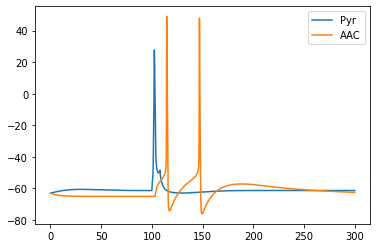

In [67]:

plt.plot(time,recVars[0],label = 'Pyr')
plt.plot(time,recVars[1],label = 'AAC')
plt.legend()

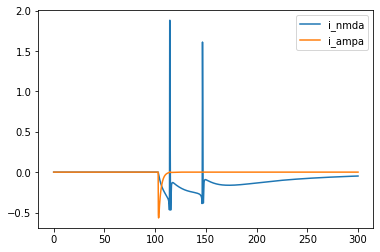

In [68]:
plt.plot(time,recVars[2],label = 'i_nmda')
plt.plot(time,recVars[3],label = 'i_ampa')
plt.legend()

In [75]:
time,recVars = run2cellModel(paramsDict)
peaks, _ = find_peaks(recVars[1], height=20)
while len(peaks) < 1:
    #paramsDict['syn.gbar_nmda'] += 0.001
    paramsDict['syn.gbar_ampa'] += 0.001
    time,recVars = run2cellModel(paramsDict)
    peaks, _ = find_peaks(recVars[1], height=20)


In [76]:
paramsDict['syn.gbar_ampa']

0.02100000000000001

In [246]:
test.dend

axoaxoniccell[6].dend[?]

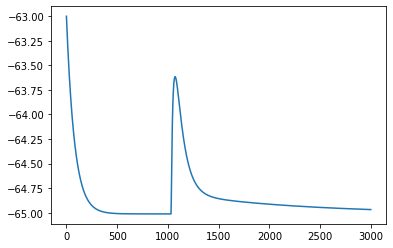

In [74]:
plt.plot(recVars[1])

In [ ]:

Pyr = h.pyramidalcell()
AAC = h.axoaxoniccell()
syn = h.pyr2int(AAC.dend[6](0.5))
#convert to list depending on how many recvars you want
recVar1 = h.Vector().record(Pyr.soma[0](0.5)._ref_v)
recVar2  = h.Vector().record(AAC.soma[0](0.5)._ref_v)
recVar3 = h.Vector().record(syn._ref_i_ampa)
recVar4 = h.Vector().record(syn._ref_i_nmda)
nc = h.NetCon(Pyr.soma[0](0.5)._ref_v, syn,10, 0.8, 1,sec=Pyr.soma[0])
paramsDict = {'filename'        : 'PN2CHN.json',
              'tstop'           : 300,
              'h.dt'            : 0.1,
              'h.L'             : 20,
              'vinit'           : -63,
              'cell1'           : Pyr,
              'cell2'           : AAC,
              'iclamp_target'   : Pyr.soma[0](0.5),
              'iclamp.delay'    : 100,
              'iclamp.dur'      : 8,
              'iclamp.amp'      : 0.6,
              'recVar1'         : recVar1,
              'recVar2'         : recVar2,
              'recVar3'         : recVar3,
              'recVar4'         : recVar4,
              'syn'             : syn,
              'syn.gbar_nmda'   : 0.008,
              'syn.gbar_ampa'   : 0.0008,
              'netCon'          : nc
              
             }
f = open(os.path.join("biophys_components","synaptic_models",paramsDict['filename']))
data =json.load(f)
keyList = list(data.keys())



iclamp = h.IClamp(paramsDict['iclamp_target'])
iclamp.delay = paramsDict['iclamp.delay']
iclamp.dur = paramsDict['iclamp.dur']
iclamp.amp = paramsDict['iclamp.amp']


syn = paramsDict['syn']
[setattr(syn,key,float(data[key])) for key in keyList if hasattr(syn,key)]

#also make into list so it can be easily switched between sims
syn.gbar_nmda = paramsDict['syn.gbar_nmda']
syn.gbar_ampa = paramsDict['syn.gbar_ampa']



#recVar1 = paramsDict['recVar1']
#recVar2 = paramsDict['recVar2']
#recVar3 = paramsDict['recVar3']
#recVar4 = paramsDict['recVar4']

h.dt=paramsDict['h.dt']
h.L = paramsDict['h.L']
h.finitialize(paramsDict['vinit'])
h.continuerun(paramsDict['tstop'])

recVar1 = np.array(recVar1)
recVar2 = np.array(recVar2)
recVar3 = np.array(recVar3)
recVar4 = np.array(recVar4)

time = np.linspace(0,paramsDict['tstop'],int(paramsDict['tstop']/h.dt )+1)#+1 for some reason
ICLAMP = np.zeros(len(time))
ICLAMP[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt+iclamp.dur)] = iclamp.amp

recVars = [recVar1,recVar2,recVar3,recVar4,ICLAMP]
#time, recVars = run2cellModel(paramsDict)
vPyr = recVars[0]
vAAC = recVars[1]
iampa = recVars[2]
inmda = recVars[3]
plt.plot(vPyr)

In [ ]:
paramsDict['tstop']

In [ ]:
['__abs__', '__add__', '__bool__', '__call__', '__class__', '__delattr__', '__delitem__', '__dir__', '__doc__', 
 '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__',
 '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__next__', '__pos__',
 '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__',
 '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', 'active', 'baseattr', 'delay', 'event',
 'get_recordvec', 'hname', 'hocobjptr', 'postcell', 'postcelllist', 'postloc', 'postseg', 'pre', 'precell', 'precelllist', 'prelist',
 'preloc', 'preseg', 'record', 'same', 'setpost', 'srcgid', 'syn', 'synlist', 'threshold', 'valid', 'wcnt', 'weight', 'x']

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(time,vPyr,label='Pyr')
plt.plot(time,vAAC,label='AAC')

#plt.plot(time,inmda*100,label='inmda*100')
#plt.plot(time,iampa*100,label='iampa*100')
#plt.xlim([90,140])
plt.ylabel('mv and uS')
plt.title('Pyr -> AAC by AMPA and NMDA')
plt.legend()

In [ ]:
recVars[0]

# Pyr -> AAC Synapse

In [ ]:
filename = 'PN2CHN.json'
f = open(os.path.join("biophys_components","synaptic_models",filename))
data =json.load(f)
keyList = list(data.keys())
    
tstop = 300
Pyr = h.pyramidalcell()
AAC = h.axoaxoniccell()

iclamp = h.IClamp(Pyr.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 8
iclamp.amp = 0.6

vPyr = h.Vector().record(Pyr.soma[0](0.5)._ref_v)
vPyrAxon = h.Vector().record(Pyr.axon[6](0.5)._ref_v)
vAAC = h.Vector().record(AAC.soma[0](0.5)._ref_v)


syn = h.pyr2int(AAC.dend[6](0.5))
[setattr(syn,key,float(data[key])) for key in keyList if hasattr(syn,key)]
syn.gbar_nmda *= 5
syn.gbar_ampa *= 5
iampa = h.Vector().record(syn._ref_i_ampa)
inmda = h.Vector().record(syn._ref_i_nmda)
netcon = h.NetCon(Pyr.soma[0](0.5)._ref_v, syn,10, 0.8, 1,sec=Pyr.soma[0])

h.dt=0.1
h.L = 20
h.finitialize(-63)

h.continuerun(tstop)

vPyr = np.array(vPyr)
vAAC = np.array(vAAC)
iampa = np.array(iampa)
inmda = np.array(inmda)

time = np.linspace(0,tstop,int(tstop/h.dt )+1)#+1 for some reason
ICLAMP = np.zeros(len(time))
ICLAMP[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt+iclamp.dur)] = iclamp.amp

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(time,vPyr,label='Pyr')
plt.plot(time,vAAC,label='AAC')

#plt.plot(time,inmda*100,label='inmda*100')
#plt.plot(time,iampa*100,label='iampa*100')
#plt.xlim([90,140])
plt.ylabel('mv and uS')
plt.title('Pyr -> AAC by AMPA and NMDA')
plt.legend()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(time,inmda,label='inmda')
plt.plot(time,iampa,label='iampa')
#plt.plot(time,ICLAMP,label='iclamp')
plt.ylabel('nA')
plt.xlabel('ms')
plt.title('Pyr->AAC')
plt.legend()

In [ ]:
secList = []
for sec in h.allsec(Pyr):
    #print(sec)
    for seg in sec.allseg():
        secList.append(seg)
        print(seg)
secList = [str(item) for item in secList]


In [ ]:
secList = secList[:secList.index('axoaxoniccell[0].soma[0](0)')]
#secList.index('pyramidalcell[1].axon[6](0.5)')

In [ ]:
secList

In [ ]:
count = 0
for i in secList:
    if '(1)' in i:
        if 'axon' not in i:
            count+=1
count

In [ ]:
Pyr.all.printnames()

In [ ]:
Pyr.soma[0].psection()

In [ ]:
Pyr.soma[0].gmax_ch_HCNp

# test for facilitation

In [ ]:
Pyr = h.pyramidalcell()
AAC = h.axoaxoniccell()

#Pyr.soma[0].gmax_ch_HCNp = 0

iclamp = h.IClamp(Pyr.axon[6](0.5))
iclamp.delay = 100
iclamp.dur = 15
iclamp.amp = 0.6


vPyr = h.Vector().record(Pyr.soma[0](0.5)._ref_v)
vPyrAxon = h.Vector().record(Pyr.axon[6](0.5)._ref_v)
vAAC = h.Vector().record(AAC.soma[0](0.5)._ref_v)
vPyrapical = h.Vector().record(Pyr.apical[0](0.5)._ref_v)


syn = h.pyr2int(AAC.soma[0](0.5))
#syn = h.ExpGABAab(Pyr.axon[6](0.5))
syn.AlphaTmax_ampa =  10.157
syn.Beta_ampa = 0.4167
syn.Cdur_ampa = 0.713
syn.gbar_ampa =  0.001
syn.Erev_ampa = 0
syn.AlphaTmax_nmda = 0.2659
syn.Beta_nmda = 0.008
syn.Cdur_nmda = 16.7650#some kind of time constant
syn.gbar_nmda = 0.0005
syn.Erev_nmda = 0
syn.initW = 100
#syn.initW_lognormal_mean = 5
#syn.initW_lognormal_std = 1.2
syn.Wmax = 25
syn.Wmin = 0.25
#syn.delay = 0.8
#syn.con_pattern = 1
syn.lambda1 = 8
syn.lambda2 = 0.01
syn.threshold1 = 0.35
syn.threshold2 = 0.4
syn.tauD1 = 4#40
syn.d1 = 0.95
syn.tauD2 = 1#70
syn.d2 = 0.9
syn.tauF = 5#45
syn.f = 1
syn.bACH = 0
syn.aDA = 1
syn.bDA = 0
syn.wACH = 0
#syn.ratio = 0.05
#syn.gaussa = 0

iAMPA = h.Vector().record(syn._ref_i_ampa)
iNMDA = h.Vector().record(syn._ref_i_nmda)
#isyn= h.Vector().record(syn._ref_i)
ffactor = h.Vector().record(syn._ref_facfactor)
netcon = h.NetCon(Pyr.apical[0](0.5)._ref_v, syn,10, 0.8, 10,sec=Pyr.apical[0])

h.dt=0.1
h.L = 20
h.finitialize(-63)
h.continuerun(300)

vPyr = np.array(vPyr)
vAAC = np.array(vAAC)
vPyrapical = np.array(vPyrapical)
iAMPA = np.array(iAMPA)
iNMDA = np.array(iNMDA)


In [ ]:
time = np.arange(0,300.1,0.1)
plt.plot(time,vAAC,label = 'AAC')
plt.plot(time,vPyr,label='Pyr')
plt.legend()


In [ ]:
plt.figure(figsize=(20,10))
plt.xlim([100,160])
plt.plot(time,iAMPA,label = 'ampa')
plt.plot(time,iNMDA,label = 'nmda')

plt.legend()

In [ ]:
plt.plot(time,ffactor)

In [ ]:
plt.plot(time,iNMDA)

In [ ]:
    "AlphaTmax_ampa": "10.1571",
    "Beta_ampa": "0.4167",
    "Cdur_ampa": "0.713",
    "gbar_ampa": "0.001",
    "Erev_ampa": "0",
    "AlphaTmax_nmda": "0.2659",
    "Beta_nmda": "0.008",
    "Cdur_nmda": "16.7650",
    "gbar_nmda": "0.0005",
    "Erev_nmda": "0",
    "initW": "1",
    "initW_lognormal_mean": 5,
    "initW_lognormal_std": 1.2,
    "Wmax": "25",
    "Wmin": "0.25",
    "delay": "0.8",
    "con_pattern": "1",
    "lambda1": "8",
    "lambda2": "0.01",
    "threshold1": "0.35",
    "threshold2": "0.4",
    "tauD1": "40",
    "d1": "0.95",
    "tauD2": "70",
    "d2": "0.9",
    "tauF": "45",
    "f": "1",
    "bACH": "0",
    "aDA": "1",
    "bDA": "0",
    "wACH": "0",
    "ratio": "0.05",
    "gaussa": "0"

# bmtk's synapse()

In [ ]:

m = 6#syn_params.get('initW_lognormal_mean')
s = 0#syn_params.get('initW_lognormal_std')
mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
std = np.sqrt(np.log((s/m)**2 + 1))
log_weight = float(np.random.lognormal(mean,std, 1))
if log_weight >= float(5*m):
    log_weight = float(5*m)
float(log_weight) # par.x(0) * rC.uniform(0.5,1.0)//rand.normal(0.5,1.5) //`rand.repick()

In [ ]:
Pyr.NumBasal

In [ ]:
Pyr.NumSoma

In [ ]:
dir(Pyr)

In [ ]:
secList.index('pyramidalcell[0].axon[6](0.5)')

In [ ]:
Pyr.axon[6].psection()

In [ ]:
len(secList)

In [ ]:
secList.index('pyramidalcell[1].axon[6](0.5)')

In [ ]:
mt = h.MechanismType(0)
mt1 = h.MechanismType(1)

In [ ]:
mname  = h.ref('')
for i in range(mt1.count()):
    mt1.select(i)
    mt1.selected(mname)
    print(mname[0])

In [ ]:
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(mname[0])

In [ ]:
dir(mt)

# testing

In [ ]:
h.topology()

In [ ]:
myCell.soma[0].children()

In [ ]:
myCell.axon[0].psection()

In [ ]:
#AAC = eval(callNames[0])
Pyr = h.pyramidalcell()


In [ ]:
for item in Pyr.axon[0].allseg():
    print(item)

In [ ]:
channelDict = Pyr.axon[0].psection()

In [ ]:
channelDict['ions']['na']

In [ ]:
channelDict

In [ ]:
h.psection(sec = Pyr.axon[5])

In [ ]:
h.psection(sec = Pyr.soma[0])

In [ ]:
static int _ode_spec1 () {_reset=0;
 {
   DW = 1e-12 * limitW * eta ( _threadargscomma_ capoolcon ) * ( lambda1 * omega ( _threadargscomma_ capoolcon , threshold1 , threshold2 ) - lambda2 * GAP1 ( _threadargscomma_ GAPstart1 , GAPstop1 ) * W ) ;
   Dr_gaba = AlphaTmax_gaba * on_gaba * ( 1.0 - r_gaba ) - Beta_gaba * r_gaba ;
   Dcapoolcon = - fCag * Afactor * Icatotal + ( Cainf - capoolcon ) / tauCa ;
   }
 return _reset;
}
 static int _ode_matsol1 () {
 DW = DW  / (1. - dt*( ( 1e-12 * limitW * eta ( _threadargscomma_ capoolcon ) )*( ( ( - ( lambda2 * GAP1 ( _threadargscomma_ GAPstart1 , GAPstop1 ) )*( 1.0 ) ) ) ) )) ;
 Dr_gaba = Dr_gaba  / (1. - dt*( ( AlphaTmax_gaba * on_gaba )*( ( ( - 1.0 ) ) ) - ( Beta_gaba )*( 1.0 ) )) ;
 Dcapoolcon = Dcapoolcon  / (1. - dt*( ( ( ( - 1.0 ) ) ) / tauCa )) ;
  return 0;
}
 /*END CVODE*/
 static int release () {_reset=0;
 {
    W = W + (1. - exp(dt*(( 1e-12 * limitW * eta ( _threadargscomma_ capoolcon ) )*( ( ( - ( lambda2 * GAP1 ( _threadargscomma_ GAPstart1 , GAPstop1 ) )*( 1.0 ) ) ) ))))*(- ( ( ( ( 1e-12 )*( limitW ) )*( eta ( _threadargscomma_ capoolcon ) ) )*( ( ( lambda1 )*( omega ( _threadargscomma_ capoolcon , threshold1 , threshold2 ) ) ) ) ) / ( ( ( ( 1e-12 )*( limitW ) )*( eta ( _threadargscomma_ capoolcon ) ) )*( ( ( - ( ( lambda2 )*( GAP1 ( _threadargscomma_ GAPstart1 , GAPstop1 ) ) )*( 1.0 ) ) ) ) ) - W) ;
    r_gaba = r_gaba + (1. - exp(dt*(( AlphaTmax_gaba * on_gaba )*( ( ( - 1.0 ) ) ) - ( Beta_gaba )*( 1.0 ))))*(- ( ( ( AlphaTmax_gaba )*( on_gaba ) )*( ( 1.0 ) ) ) / ( ( ( AlphaTmax_gaba )*( on_gaba ) )*( ( ( - 1.0 ) ) ) - ( Beta_gaba )*( 1.0 ) ) - r_gaba) ;
    capoolcon = capoolcon + (1. - exp(dt*(( ( ( - 1.0 ) ) ) / tauCa)))*(- ( ( ( - fCag )*( Afactor ) )*( Icatotal ) + ( ( Cainf ) ) / tauCa ) / ( ( ( ( - 1.0 ) ) ) / tauCa ) - capoolcon) ;
   }
  return 0;
}

In [ ]:
#using a synapse

In [ ]:
Pyr.axon[0](1).ri()

In [ ]:
Pyr.soma[0](1).ri()